In [1]:
import torch
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import torch.utils.data as pydata
from torchsummary import summary
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import random
from matplotlib import cm
import spectral as spy
from sklearn import metrics
from sklearn import preprocessing
import time
from torch.autograd import Variable
from H_datapy import *

#import CCnet2BModel1 as CC2B
import CCnetConcat2B1 as CCCon2B

import torch.nn.functional as F
from autis import *
#from functions import CrissCrossAttention
from thop import profile
samples_type=['ratio','same_num'][0]
import logging

Detected CUDA files, patching ldflags
Emitting ninja build file /home/shsun/Dingwenda/ENL-FCN/cc_attention/build/build.ninja...
Building extension module rcca...
Loading extension module rcca...


In [2]:
def get_logger(filename, verbosity=1, name=None):
    level_dict = {0: logging.DEBUG, 1: logging.INFO, 2: logging.WARNING}
    formatter = logging.Formatter(
        "[%(asctime)s][%(filename)s][%(levelname)s] %(message)s"
    )
    logger = logging.getLogger(name)
    logger.setLevel(level_dict[verbosity])

    fh = logging.FileHandler(filename, "a")
    fh.setFormatter(formatter)
    logger.addHandler(fh)

    sh = logging.StreamHandler()
    sh.setFormatter(formatter)
    logger.addHandler(sh)

    return logger

In [3]:
FLAG=1
curr_train_ratio =0.1
Seed_List=[0]
if FLAG == 1:
    data_mat = sio.loadmat('./Datasets/IndianPines/Indian_pines_corrected.mat')
    data = data_mat['indian_pines_corrected']
    gt_mat = sio.loadmat('./Datasets/IndianPines/Indian_pines_gt.mat')
    gt = gt_mat['indian_pines_gt']
    # 参数预设
    train_ratio = 0.05  # 训练集比例。注意，训练集为按照‘每类’随机选取
    val_ratio = 0.01 # 测试集比例.注意，验证集选取为从测试集整体随机选取，非按照每类
    class_count = 16  # 样本类别数
    learning_rate = 5e-4  # 学习率
    weight_decay = 2e-5
    max_epoch = 1800  # 迭代次数
    split_height = 1
    split_width = 1
    dataset_name = "indian"
train_samples_per_class=curr_train_ratio#当定义为每类样本个数时,则该参数更改为训练样本数
val_samples=class_count


train_ratio=curr_train_ratio
if split_height == split_width == 1:
        EDGE = 0
else:
        EDGE = 5

cmap = cm.get_cmap('jet', class_count + 1)
plt.set_cmap(cmap)
m, n, d = data.shape  # 高光谱数据的三个维度
n_bands=d

data = np.reshape(data, [m * n, d])
minMax = preprocessing.StandardScaler()
data = minMax.fit_transform(data)
data = np.reshape(data, [m, n, d])


for curr_seed in Seed_List:
    # step2:随机10%数据作为训练样本。方式：给出训练数据与测试数据的GT
    random.seed(curr_seed)
    gt_reshape = np.reshape(gt, [-1])
    train_rand_idx = []
    val_rand_idx = []

    if samples_type=='ratio':
        for i in range(class_count):
            idx = np.where(gt_reshape == i + 1)[-1]
            samplesCount = len(idx)
            rand_list = [i for i in range(samplesCount)]  # 用于随机的列表
            rand_idx = random.sample(rand_list, np.ceil(samplesCount * train_ratio).astype('int32'))  # 随机数数量 四舍五入(改为上取整)
            rand_real_idx_per_class = idx[rand_idx]
            train_rand_idx.append(rand_real_idx_per_class)
        train_rand_idx = np.array(train_rand_idx)
        train_data_index = []
        for c in range(train_rand_idx.shape[0]):
            a = train_rand_idx[c]
            for j in range(a.shape[0]):
                train_data_index.append(a[j])
        train_data_index = np.array(train_data_index)

        ##将测试集（所有样本，包括训练样本）也转化为特定形式
        train_data_index = set(train_data_index)
        all_data_index = [i for i in range(len(gt_reshape))]
        all_data_index = set(all_data_index)

        # 背景像元的标签
        background_idx = np.where(gt_reshape == 0)[-1]
        background_idx = set(background_idx)
        test_data_index = all_data_index - train_data_index - background_idx

        # 从测试集中随机选取部分样本作为验证集
        val_data_count = int(val_ratio * (len(test_data_index) + len(train_data_index)))  # 验证集数量
        val_data_index = random.sample(test_data_index, val_data_count)
        val_data_index = set(val_data_index)
        test_data_index = test_data_index - val_data_index  # 由于验证集为从测试集分裂出，所以测试集应减去验证集

        # 将训练集 验证集 测试集 整理
        test_data_index = list(test_data_index)
        train_data_index = list(train_data_index)
        val_data_index = list(val_data_index)

    if samples_type=='same_num':
        for i in range(class_count):
            idx = np.where(gt_reshape == i + 1)[-1]
            samplesCount = len(idx)
            real_train_samples_per_class=train_samples_per_class
            rand_list = [i for i in range(samplesCount)]  # 用于随机的列表
            if real_train_samples_per_class>=samplesCount:
                #real_train_samples_per_class=samplesCount
                real_train_samples_per_class=int(train_samples_per_class/2)
                # val_samples_per_class=0
            rand_idx = random.sample(rand_list,
                                        real_train_samples_per_class)  # 随机数数量 四舍五入(改为上取整)
            rand_real_idx_per_class_train = idx[rand_idx[0:real_train_samples_per_class]]
            train_rand_idx.append(rand_real_idx_per_class_train)
            # if val_samples_per_class>0:
            #     rand_real_idx_per_class_val = idx[rand_idx[-val_samples_per_class:]]
            #     val_rand_idx.append(rand_real_idx_per_class_val)
        train_rand_idx = np.array(train_rand_idx)
        val_rand_idx = np.array(val_rand_idx)
        train_data_index = []
        for c in range(train_rand_idx.shape[0]):
            a = train_rand_idx[c]
            for j in range(a.shape[0]):
                train_data_index.append(a[j])
        train_data_index = np.array(train_data_index)


        train_data_index = set(train_data_index)
        # val_data_index = set(val_data_index)
        all_data_index = [i for i in range(len(gt_reshape))]
        all_data_index = set(all_data_index)

        # 背景像元的标签
        background_idx = np.where(gt_reshape == 0)[-1]
        background_idx = set(background_idx)
        test_data_index = all_data_index - train_data_index  - background_idx

        # 从测试集中随机选取部分样本作为验证集
        val_data_count = int(val_samples)  # 验证集数量
        val_data_index = random.sample(test_data_index, val_data_count)
        val_data_index = set(val_data_index)

        test_data_index=test_data_index-val_data_index
        # 将训练集 验证集 测试集 整理
        test_data_index = list(test_data_index)
        train_data_index = list(train_data_index)
        val_data_index = list(val_data_index)

    # 获取训练样本的标签图
    train_samples_gt = np.zeros(gt_reshape.shape)
    for i in range(len(train_data_index)):
        train_samples_gt[train_data_index[i]] = gt_reshape[train_data_index[i]]
        pass
    Train_Label=np.reshape(train_samples_gt, [m,n])


    # 获取测试样本的标签图
    test_samples_gt = np.zeros(gt_reshape.shape)
    for i in range(len(test_data_index)):
        test_samples_gt[test_data_index[i]] = gt_reshape[test_data_index[i]]
        pass

    Test_Label = np.reshape(test_samples_gt, [m, n])  # 测试样本图

    # 获取验证集样本的标签图
    val_samples_gt = np.zeros(gt_reshape.shape)
    for i in range(len(val_data_index)):
        val_samples_gt[val_data_index[i]] = gt_reshape[val_data_index[i]]
        pass
    Val_Label=np.reshape(val_samples_gt,[m,n])

            #############将train 和 test 和val 样本标签转化为向量形式###################
    # 训练集
    train_samples_gt = np.reshape(train_samples_gt, [m * n])
    train_samples_gt_vector = np.zeros([m * n, class_count], np.float)
    for i in range(train_samples_gt.shape[0]):
        class_idx = train_samples_gt[i]
        if class_idx != 0:
            temp = np.zeros([class_count])
            temp[int(class_idx - 1)] = 1
            train_samples_gt_vector[i] = temp
    train_samples_gt_vector = np.reshape(train_samples_gt_vector, [m, n, class_count])
    # 测试集
    test_samples_gt = np.reshape(test_samples_gt, [m * n])
    test_samples_gt_vector = np.zeros([m * n, class_count], np.float)
    for i in range(test_samples_gt.shape[0]):
        class_idx = test_samples_gt[i]
        if class_idx != 0:
            temp = np.zeros([class_count])
            temp[int(class_idx - 1)] = 1
            test_samples_gt_vector[i] = temp
    test_samples_gt_vector = np.reshape(test_samples_gt_vector, [m, n, class_count])
    # 验证集
    val_samples_gt = np.reshape(val_samples_gt, [m * n])
    val_samples_gt_vector = np.zeros([m * n, class_count], np.float)
    for i in range(val_samples_gt.shape[0]):
        class_idx = val_samples_gt[i]
        if class_idx != 0:
            temp = np.zeros([class_count])
            temp[int(class_idx - 1)] = 1
            val_samples_gt_vector[i] = temp
    val_samples_gt_vector = np.reshape(val_samples_gt_vector, [m, n, class_count])

    ############制作训练数据和测试数据的gt掩膜.根据GT将带有标签的像元设置为全1向量##############
    # 训练集
    train_label_mask = np.zeros([m * n, class_count])
    temp_ones = np.ones([class_count])
    train_samples_gt = np.reshape(train_samples_gt, [m * n])
    for i in range(m * n):
        if train_samples_gt[i] != 0:
            train_label_mask[i] = temp_ones
    train_label_mask = np.reshape(train_label_mask, [m, n, class_count])

    # 测试集
    test_label_mask = np.zeros([m * n, class_count])
    temp_ones = np.ones([class_count])
    test_samples_gt = np.reshape(test_samples_gt, [m * n])
    for i in range(m * n):
        if test_samples_gt[i] != 0:
            test_label_mask[i] = temp_ones
    test_label_mask = np.reshape(test_label_mask, [m, n, class_count])

    # 验证集
    val_label_mask = np.zeros([m * n, class_count])
    temp_ones = np.ones([class_count])
    val_samples_gt = np.reshape(val_samples_gt, [m * n])
    for i in range(m * n):
        if val_samples_gt[i] != 0:
            val_label_mask[i] = temp_ones
    val_label_mask = np.reshape(val_label_mask, [m, n, class_count])

    # 将数据扩展一维，以满足网络输入需求
    # t1=Train_Label
    # t1[Train_Label>0]=1
    # num=t1.sum()
    # t2=Test_Label
    # t2[Test_Label>0]=1
    # num2=t2.sum()
    Train_Split_Data, Train_Split_GT = SpiltHSI(data, Train_Label, [split_height, split_width], EDGE)
    Test_Split_Data, Test_Split_GT = SpiltHSI(data, Test_Label, [split_height, split_width], EDGE)
    _, patch_height, patch_width, bands = Train_Split_Data.shape
    patch_height -= EDGE * 2
    patch_width -= EDGE * 2





    zero_vector = np.zeros([class_count])
    all_label_mask = np.ones([1, m, n, class_count])  # 设置一个全1的mask，使得网络输出所有分类标签



train_h=HData((np.transpose(Train_Split_Data,(0,3,1,2)).astype("float32"), Train_Split_GT), None)
test_h=HData((np.transpose(Test_Split_Data,(0,3,1,2)).astype("float32"), Test_Split_GT), None)
trainloader=torch.utils.data.DataLoader(train_h)
testloader=torch.utils.data.DataLoader(test_h)

use_cuda = torch.cuda.is_available()



<Figure size 432x288 with 0 Axes>

In [4]:
threshold=0.001
model = CCCon2B.SSCDNonLModel_gcn_2(16, 200, 200)
criterion = torch.nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=2e-5) # Criss Cross Model CCNet 2B parallel

In [12]:
model2 = CCCon2B.SSCDNonLModel_gcn3(16, 200, 200,0.01)
criterion = torch.nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=2e-5)

In [16]:
model3 = CCCon2B.SSCDNonLModel(16, 200, 200)
criterion = torch.nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.Adam(model3.parameters(), lr=learning_rate, weight_decay=2e-5)

In [21]:
import tensorwatch as tw
import torchvision.models
model5 = CCCon2B.SSCDNonLModel_gcn_2(9, 103, 200)
criterion = torch.nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.Adam(model5.parameters(), lr=learning_rate, weight_decay=2e-5)
tw.model_stats(model5,[1,103,610,340])

RuntimeError: running_mean should contain 103 elements not 200

In [18]:
import tensorwatch as tw
import torchvision.models
model4 = CCCon2B.SSCDNonLModel(9, 103, 200)
criterion = torch.nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.Adam(model4.parameters(), lr=learning_rate, weight_decay=2e-5)
tw.model_stats(model4,[1,103,610,340])

RuntimeError: [enforce fail at CPUAllocator.cpp:64] . DefaultCPUAllocator: can't allocate memory: you tried to allocate 787290400 bytes. Error code 12 (Cannot allocate memory)


In [17]:
import tensorwatch as tw
import torchvision.models

tw.model_stats(model3,[1,200,145,145])

,module name,input shape,output_shape,parameters,infer memory(MB),MAdd,Flops,MemRead(B),MemWrite(B),duration
0,b1,"(1, 200, 145, 145)","(1, 200, 145, 145)",400,16.040802001953125,"16,820,000","8,410,000","16,821,600","16,820,000",0.003227
1,con1,"(1, 200, 145, 145)","(1, 200, 145, 145)","40,200",16.040802001953125,"1,682,000,000","845,205,000","16,980,800","16,820,000",0.018433
2,s1,"(1, 200, 145, 145)","(1, 200, 145, 145)",0,16.040802001953125,0,0,0,0,0.002755
3,cond1,"(1, 200, 145, 145)","(1, 200, 145, 145)","5,200",16.040802001953125,"210,250,000","109,330,000","16,840,800","16,820,000",0.010990
4,sd1,"(1, 200, 145, 145)","(1, 200, 145, 145)",0,16.040802001953125,0,0,0,0,0.003234
5,b2,"(1, 400, 145, 145)","(1, 400, 145, 145)",800,32.08160400390625,"33,640,000","16,820,000","33,643,200","33,640,000",0.008647
6,con2,"(1, 400, 145, 145)","(1, 200, 145, 145)","80,200",16.040802001953125,"3,364,000,000","1,686,205,000","33,960,800","16,820,000",0.029877
7,s2,"(1, 200, 145, 145)","(1, 200, 145, 145)",0,16.040802001953125,0,0,0,0,0.002722
8,cond2,"(1, 200, 145, 145)","(1, 25, 145, 145)","5,025",2.0051002502441406,"210,250,000","105,650,625","16,840,100","2,102,500",0.041589
9,sd2,"(1, 25, 145, 145)","(1, 25, 145, 145)",0,2.0051002502441406,0,0,0,0,0.000393


In [21]:
import tensorwatch as tw
import torchvision.models

tw.model_stats(model,[1,200,145,145])

,module name,input shape,output_shape,parameters,infer memory(MB),MAdd,Flops,MemRead(B),MemWrite(B),duration
0,b1,"(1, 200, 145, 145)","(1, 200, 145, 145)",400,16.040802001953125,"16,820,000","8,410,000","16,821,600","16,820,000",0.005461
1,con1,"(1, 200, 145, 145)","(1, 200, 145, 145)","40,200",16.040802001953125,"1,682,000,000","845,205,000","16,980,800","16,820,000",0.139384
2,s1,"(1, 200, 145, 145)","(1, 200, 145, 145)",0,16.040802001953125,0,0,0,0,0.045903
3,cond1,"(1, 200, 145, 145)","(1, 200, 145, 145)","5,200",16.040802001953125,"210,250,000","109,330,000","16,840,800","16,820,000",0.028337
4,sd1,"(1, 200, 145, 145)","(1, 200, 145, 145)",0,16.040802001953125,0,0,0,0,0.003316
5,trans,"(1, 200, 145, 145)","(1, 1, 145, 145)",201,0.08020401000976562,"8,410,000","4,226,025","16,820,804","84,100",0.007890
6,att.conv_mask,"(1, 200, 145, 145)","(1, 1, 145, 145)",201,0.08020401000976562,"8,410,000","4,226,025","16,820,804","84,100",0.046604
7,att.softmax,"(1, 1, 21025)","(1, 1, 21025)",0,0.08020401000976562,"63,074",0,0,0,0.110557
8,conv1,"(21025, 1)","(21025, 100)",200,8.020401000976562,0,0,0,0,0.425358
9,conv2,"(21025, 100)","(21025, 200)","20,200",16.040802001953125,0,0,0,0,0.528941


In [13]:
import tensorwatch as tw
import torchvision.models
tw.model_stats(model2,[1,200,145,145])

RuntimeError: [enforce fail at CPUAllocator.cpp:64] . DefaultCPUAllocator: can't allocate memory: you tried to allocate 7072810000 bytes. Error code 12 (Cannot allocate memory)


In [7]:
#model = CCCon2B.SSCDNonLModel_gcn6(class_count, 200, 150)
import tensorwatch as tw
import torchvision.models

# tw.model_stats(model.cuda(),[1, 200,145, 145])
#print(model)
if use_cuda: torch.backends.cudnn.benchmark = True
if use_cuda: model.cuda()
criterion = torch.nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=2e-5)
print('lr: ',learning_rate, '  weight_dacay: ', weight_decay)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.003, momentum=0.9, weight_decay=1e-4, nesterov=True)


#best_acc = -1



lr:  0.0005   weight_dacay:  2e-05


lr:  0.0005   weight_dacay:  2e-05
eep 0  test 2141 9116 OA 0.23486178148310663 AA 0.08297551548361237 kappa 0.0673574308741609
eep 10  test 3910 9116 OA 0.42891619131197894 AA 0.18200910825105535 kappa 0.28746820358551506
eep 20  test 4274 9116 OA 0.468845985081176 AA 0.22152546528024042 kappa 0.34550442196304776
eep 30  test 4562 9116 OA 0.5004387889425187 AA 0.24376755939924563 kappa 0.39012818700031116
eep 40  test 5043 9116 OA 0.5532031592803861 AA 0.2837203030892157 kappa 0.46119485880527233
eep 50  test 6177 9116 OA 0.677599824484423 AA 0.3708317707664568 kappa 0.6206896703064394
eep 60  test 7566 9116 OA 0.8299692847740237 AA 0.5472572760634606 kappa 0.8036883657493398
eep 70  test 8435 9116 OA 0.9252961825362 AA 0.7053584782710512 kappa 0.9144903460874618
eep 80  test 8727 9116 OA 0.9573277753400614 AA 0.7671963490440076 kappa 0.9512565427315277
eep 90  test 8828 9116 OA 0.9684071961386573 AA 0.7792149670785689 kappa 0.963925594560149
eep 100  test 8882 9116 OA 0.9743308468626

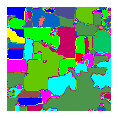

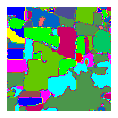

In [64]:
threshold=0.001
model = CCCon2B.SSCDNonLModel_gcns(class_count, 200, 150) 
import tensorwatch as tw
import torchvision.models

# tw.model_stats(model.cuda(),[1, 200,145, 145])
#print(model)
if use_cuda: torch.backends.cudnn.benchmark = True
if use_cuda: model.cuda()
criterion = torch.nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=2e-5)
print('lr: ',learning_rate, '  weight_dacay: ', weight_decay)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.003, momentum=0.9, weight_decay=1e-4, nesterov=True)


best=[]
output_l=[]
for num in range(2):
    best_acc=-1
    
    for eep in range(1800):
        for batch_idx, (inputs, labels) in enumerate(trainloader):#batch_idx是enumerate（）函数自带的索引，从0开始
            if use_cuda:
                inputs, labels = inputs.cuda(), labels.cuda()
            inputs, labels = torch.autograd.Variable(inputs), torch.autograd.Variable(labels)
            optimizer.zero_grad()
            #print(inputs.shape)
            #with autocast():

            output= model(inputs)

            loss=criterion(output, labels.long())
            
            optimizer.zero_grad()   # 所有参数的梯度清零
            loss.backward(retain_graph=True)         #即反向传播求梯度
            optimizer.step()        #调用optimizer进行梯度下降更新参数
            # Scales loss. 为了梯度放大.
            #scaler.scale(loss).backward()

            # scaler.step() 首先把梯度的值unscale回来.
            # 如果梯度的值不是 infs 或者 NaNs, 那么调用optimizer.step()来更新权重,
            # 否则，忽略step调用，从而保证权重不更新（不被破坏）
            #scaler.step(optimizer)

            # 准备着，看是否要增大scaler
            #scaler.update()

        if eep%10==0:
            Output=[]
            for Testbatch_idx, (Testinputs, Testtargets) in enumerate(testloader):#batch_idx是enumerate（）函数自带的索引，从0开始
                if use_cuda:
                    Testinputs, Testtargets = Testinputs.cuda(), Testtargets.cuda()
                Testinputs, Testtargets = torch.autograd.Variable(Testinputs), torch.autograd.Variable(Testtargets)
                Testoutput = model(Testinputs)
                Testoutput=Testoutput.data.cpu().numpy()
                Testoutput = np.transpose(Testoutput,(0,2,3,1))
                Output.append(Testoutput[0])

            OutputWhole = PatchStack(Output, m, n, patch_height, patch_width, split_height, split_width, EDGE, class_count+1)
            
            AC, OA, AA, rightNum, testNum= ClassificationAccuracy(OutputWhole, Test_Label, class_count+1)
            kappa = Kappa(OutputWhole, Test_Label, class_count+1)
            if  OA>best_acc :
                best_acc=OA 
                output_best = OutputWhole
            print("eep", eep, " test", rightNum, testNum, "OA", OA, "AA", AA, "kappa", kappa)
            #print(OA, AA, kappa, AC)
            #logger.info('Epoch:[{}/{}]\t test={}\{} OA={:.7f} AA={:.7f} kappa={:.7f} AC=[{}]'.format(eep , max_epoch, rightNum, testNum ,OA,AA,kappa,AC))
        if eep==860 :
            OA=np.round(OA*100, decimals=2)
            OutputWhole_show = PatchStack(Output, m, n, patch_height, patch_width, split_height, split_width, EDGE, class_count+1)
            Draw_Classification_Map(OutputWhole, '/home/shsun/Dingwenda/ENL-FCN/ResultImage/' + dataset_name + '_CC2B_' + str(train_ratio) + '_' + str(OA))

        #if loss.data<=0.00005:
            #break
    best.append(best_acc)
    output_l.append(output_best)

    #logger.info('finish training!')

model.train()
model.eval()
print("best_acc", best)

In [66]:
enc = np.load('output.npz')

In [72]:
enc.keys()

KeysView(<numpy.lib.npyio.NpzFile object at 0x7f4af0122550>)

In [74]:
print(enc['arr_0'][0].shape)

(144, 144)


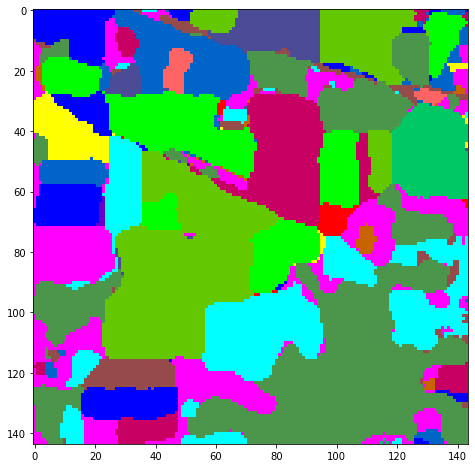

In [75]:
import spectral
classification=spectral.imshow(classes=enc['arr_0'][0].astype(int),figsize=(8,8))

ImageView object:
  Interpolation       :  <default>

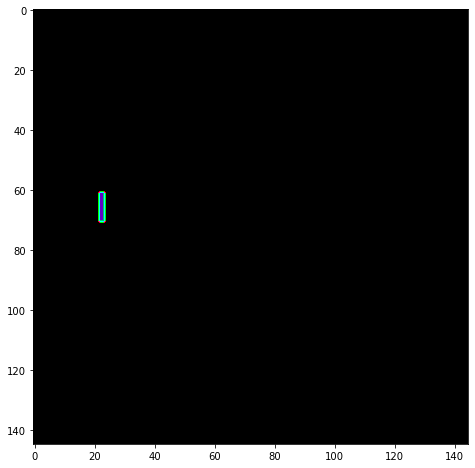

In [15]:
target_9=gt
m,n=gt.shape
for i in range(m):
    for j in range(n):
        if gt[i,j] !=9:
            target_9[i,j]=0
spectral.imshow(classes=target_9.astype(int),figsize=(8,8))

In [69]:
print(output3.shape)

(144, 144)


In [ ]:
def imshow(output,gt):
    m, n = OutputWhole.shape
    #output=np.reshape(output, [classcount, m*n])
    #target=np.reshape(target, [1, ])  #groundtruth label
    #m,n=output.size()
    #L_output=np.argmax(output, axis=0) # output label
    #_,L_output=torch.topk(output, 1, 0, True)
    target=gt
    output3=output_best

    count=0
    for i in range(m):
        for j in range(n):
            if target[i, j]==0:
                count=count+1
                output3[i,j] = target[i,j]
    spectral.imshow(classes=output3.astype(int),figsize=(8,8))
#spectral.imshow(classes=gt.astype(int),figsize=(8,8))

ImageView object:
  Interpolation       :  <default>

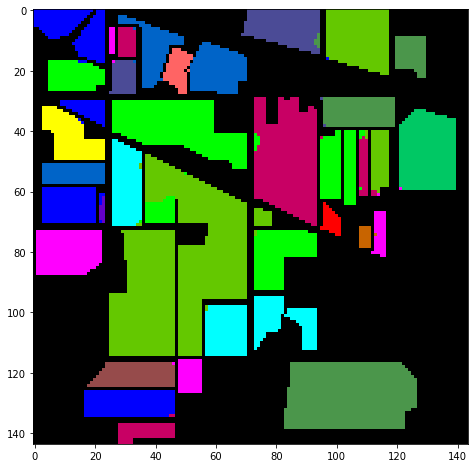

In [44]:
m, n = OutputWhole.shape
#output=np.reshape(output, [classcount, m*n])
#target=np.reshape(target, [1, ])  #groundtruth label
#m,n=output.size()
#L_output=np.argmax(output, axis=0) # output label
#_,L_output=torch.topk(output, 1, 0, True)
target=gt
output3=output_best

count=0
for i in range(m):
    for j in range(n):
        if target[i, j]==0:
            count=count+1
            output3[i,j] = target[i,j]
spectral.imshow(classes=output3.astype(int),figsize=(8,8))
#spectral.imshow(classes=gt.astype(int),figsize=(8,8))

ImageView object:
  Interpolation       :  <default>

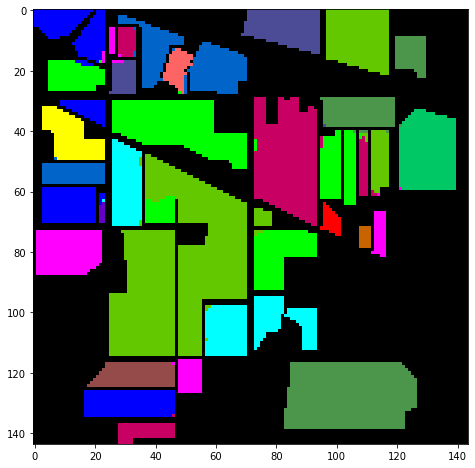

In [33]:
m, n = OutputWhole.shape
#output=np.reshape(output, [classcount, m*n])
#target=np.reshape(target, [1, ])  #groundtruth label
#m,n=output.size()
#L_output=np.argmax(output, axis=0) # output label
#_,L_output=torch.topk(output, 1, 0, True)
target=gt
output2=output_best

count=0
for i in range(m):
    for j in range(n):
        if target[i, j]==0:
            count=count+1
            output2[i,j] = target[i,j]
spectral.imshow(classes=output2.astype(int),figsize=(8,8))
#spectral.imshow(classes=gt.astype(int),figsize=(8,8))

ImageView object:
  Interpolation       :  <default>

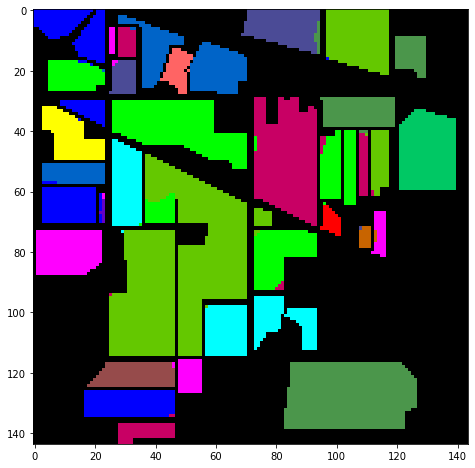

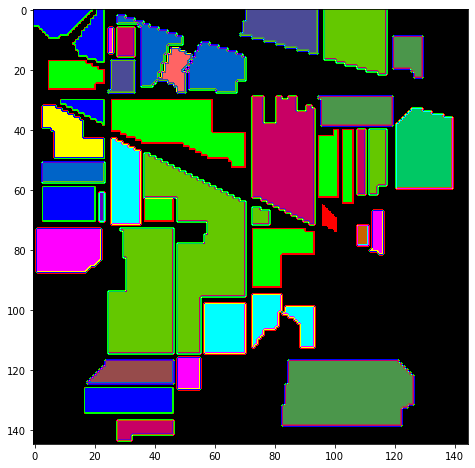

In [15]:
m, n = OutputWhole.shape
#output=np.reshape(output, [classcount, m*n])
#target=np.reshape(target, [1, ])  #groundtruth label
#m,n=output.size()
#L_output=np.argmax(output, axis=0) # output label
#_,L_output=torch.topk(output, 1, 0, True)
target=gt
output=output_best

count=0
for i in range(m):
    for j in range(n):
        if target[i, j]==0:
            count=count+1
            output[i,j] = target[i,j]
spectral.imshow(classes=output.astype(int),figsize=(8,8))
spectral.imshow(classes=gt.astype(int),figsize=(8,8))

ImageView object:
  Interpolation       :  <default>

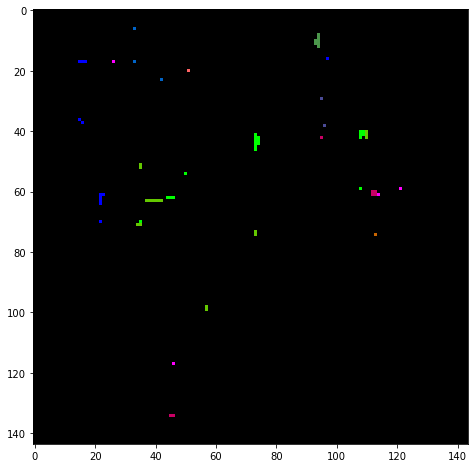

In [45]:
errors3=output3
for i in range(m):
    for j in range(n):
        if output3[i,j] == gt[i,j]:
            errors3[i,j] =0

spectral.imshow(classes=errors3.astype(int),figsize=(8,8))

ImageView object:
  Interpolation       :  <default>

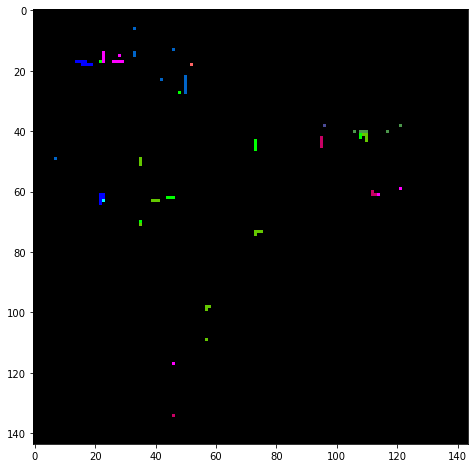

In [34]:
errors2=output2
for i in range(m):
    for j in range(n):
        if output2[i,j] == gt[i,j]:
            errors2[i,j] =0

spectral.imshow(classes=errors2.astype(int),figsize=(8,8))

ImageView object:
  Interpolation       :  <default>

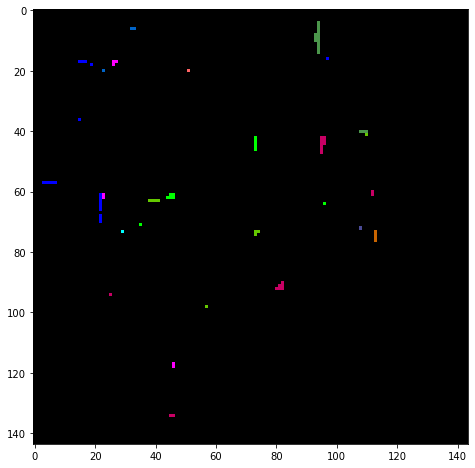

In [16]:
errors=output
for i in range(m):
    for j in range(n):
        if output[i,j] == gt[i,j]:
            errors[i,j] =0

spectral.imshow(classes=errors.astype(int),figsize=(8,8))

# 消融

In [12]:
threshold=0.001
model_ab = CCCon2B.SSCDNonLModel_ablation(class_count, 200, 150) 
#model = CCCon2B.SSCDNonLModel_gcn6(class_count, 200, 150)
import tensorwatch as tw
import torchvision.models

# tw.model_stats(model.cuda(),[1, 200,145, 145])
print(model_ab)
if use_cuda: torch.backends.cudnn.benchmark = True
if use_cuda: model_ab.cuda()
criterion = torch.nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.Adam(model_ab.parameters(), lr=learning_rate, weight_decay=2e-5)
print('lr: ',learning_rate, '  weight_dacay: ', weight_decay)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.003, momentum=0.9, weight_decay=1e-4, nesterov=True)


best_acc = -1



SSCDNonLModel_ablation(
  (b1): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (con1): Conv2d(200, 150, kernel_size=(1, 1), stride=(1, 1))
  (s1): Sigmoid()
  (cond1): Conv2d(150, 150, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=150)
  (sd1): Sigmoid()
  (b2): BatchNorm2d(350, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (con2): Conv2d(350, 150, kernel_size=(1, 1), stride=(1, 1))
  (s2): Sigmoid()
  (cond2): Conv2d(150, 25, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=25)
  (sd2): Sigmoid()
  (b4): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bcat): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (con4): Conv2d(50, 150, kernel_size=(1, 1), stride=(1, 1))
  (s4): Sigmoid()
  (cond4): Conv2d(150, 150, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=150)
  (sd4): Sigmoid()
  (b5): BatchNorm2d(175, eps=1e-05, momentum=0.1, aff

In [16]:
for eep in range(1000):
    for batch_idx, (inputs, labels) in enumerate(trainloader):#batch_idx是enumerate（）函数自带的索引，从0开始
        if use_cuda:
            inputs, labels = inputs.cuda(), labels.cuda()
        inputs, labels = torch.autograd.Variable(inputs), torch.autograd.Variable(labels)
        optimizer.zero_grad()
        #print(inputs.shape)
        #with autocast():

        output= model_ab(inputs)

        loss=criterion(output, labels.long())
        
        optimizer.zero_grad()   # 所有参数的梯度清零
        loss.backward(retain_graph=True)         #即反向传播求梯度
        optimizer.step()        #调用optimizer进行梯度下降更新参数
        # Scales loss. 为了梯度放大.
        #scaler.scale(loss).backward()

        # scaler.step() 首先把梯度的值unscale回来.
        # 如果梯度的值不是 infs 或者 NaNs, 那么调用optimizer.step()来更新权重,
        # 否则，忽略step调用，从而保证权重不更新（不被破坏）
        #scaler.step(optimizer)

        # 准备着，看是否要增大scaler
        #scaler.update()

    if eep%10==0:
        Output=[]
        for Testbatch_idx, (Testinputs, Testtargets) in enumerate(testloader):#batch_idx是enumerate（）函数自带的索引，从0开始
            if use_cuda:
                Testinputs, Testtargets = Testinputs.cuda(), Testtargets.cuda()
            Testinputs, Testtargets = torch.autograd.Variable(Testinputs), torch.autograd.Variable(Testtargets)
            Testoutput = model_ab(Testinputs)
            Testoutput=Testoutput.data.cpu().numpy()
            Testoutput = np.transpose(Testoutput,(0,2,3,1))
            Output.append(Testoutput[0])

        OutputWhole = PatchStack(Output, m, n, patch_height, patch_width, split_height, split_width, EDGE, class_count+1)
        AC, OA, AA, rightNum, testNum= ClassificationAccuracy(OutputWhole, Test_Label, class_count+1)
        kappa = Kappa(OutputWhole, Test_Label, class_count+1)
        print("eep", eep, " test", rightNum, testNum, "OA", OA, "AA", AA, "kappa", kappa)
        print(OA, AA, kappa, AC)
        #logger.info('Epoch:[{}/{}]\t test={}\{} OA={:.7f} AA={:.7f} kappa={:.7f} AC=[{}]'.format(eep , max_epoch, rightNum, testNum ,OA,AA,kappa,AC))
    if eep==860 :
        OA=np.round(OA*100, decimals=2)
        OutputWhole_ab_show = PatchStack(Output, m, n, patch_height, patch_width, split_height, split_width, EDGE, class_count+1)
        #Draw_Classification_Map(OutputWhole, '/home/shsun/Dingwenda/ENL-FCN/ResultImage/' + dataset_name + '_CC2B_' + str(train_ratio) + '_' + str(OA))

    if loss.data<=0.00005:
        break


#logger.info('finish training!')

model_ab.train()
model_ab.eval()

976305397103993 0.7912051810937608 0.9729487061056812 [0.04878049 0.97562893 0.99321574 0.96208531 1.         0.99539877
 0.         1.         0.         0.96631823 0.99771272 0.9904943
 0.98907104 0.99910714 0.91014493 0.8313253 ]
eep 400  test 8912 9116 OA 0.9776217639315489 AA 0.8080020648105394 kappa 0.9744538212044147
0.9776217639315489 0.8080020648105394 0.9744538212044147 [0.31707317 0.97562893 0.99321574 0.96208531 1.         0.99539877
 0.         1.         0.         0.96631823 0.99817017 0.9904943
 0.98907104 0.99910714 0.91014493 0.8313253 ]
eep 410  test 8920 9116 OA 0.9784993418165863 AA 0.8187178641625735 kappa 0.9754568111491937
0.9784993418165863 0.8187178641625735 0.9754568111491937 [0.46341463 0.97484277 0.99321574 0.96682464 1.         0.99386503
 0.         1.         0.         0.96747967 0.99817017 0.9904943
 0.98360656 0.99910714 0.91304348 0.85542169]
eep 420  test 8929 9116 OA 0.9794866169372531 AA 0.8284716983573678 kappa 0.9765836679005389
0.97948661693725

SSCDNonLModel_ablation(
  (b1): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (con1): Conv2d(200, 150, kernel_size=(1, 1), stride=(1, 1))
  (s1): Sigmoid()
  (cond1): Conv2d(150, 150, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=150)
  (sd1): Sigmoid()
  (b2): BatchNorm2d(350, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (con2): Conv2d(350, 150, kernel_size=(1, 1), stride=(1, 1))
  (s2): Sigmoid()
  (cond2): Conv2d(150, 25, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=25)
  (sd2): Sigmoid()
  (b4): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bcat): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (con4): Conv2d(50, 150, kernel_size=(1, 1), stride=(1, 1))
  (s4): Sigmoid()
  (cond4): Conv2d(150, 150, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=150)
  (sd4): Sigmoid()
  (b5): BatchNorm2d(175, eps=1e-05, momentum=0.1, aff

ImageView object:
  Interpolation       :  <default>

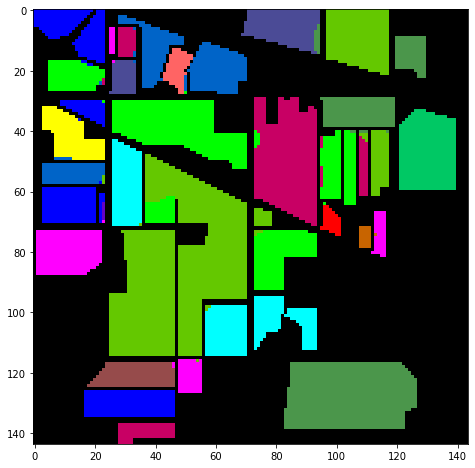

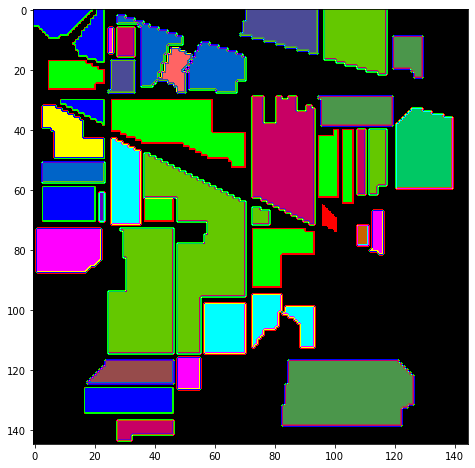

In [18]:
import spectral
m, n = OutputWhole_ab_show.shape
#output=np.reshape(output, [classcount, m*n])
#target=np.reshape(target, [1, ])  #groundtruth label
#m,n=output.size()
#L_output=np.argmax(output, axis=0) # output label
#_,L_output=torch.topk(output, 1, 0, True)
target=gt
output_a=OutputWhole_ab_show

count=0
for i in range(m):
    for j in range(n):
        if target[i, j]==0:
            count=count+1
            output_a[i,j] = target[i,j]
spectral.imshow(classes=output_a.astype(int),figsize=(8,8))
spectral.imshow(classes=gt.astype(int),figsize=(8,8))

ImageView object:
  Interpolation       :  <default>

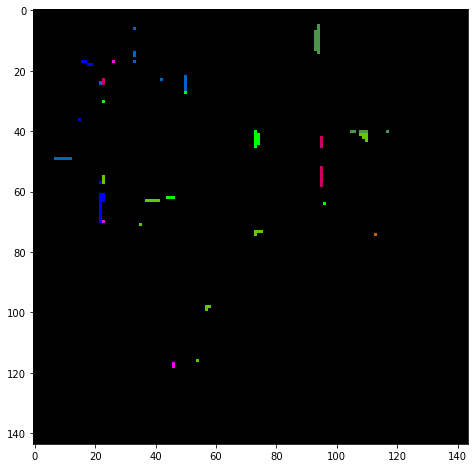

In [19]:
errors_a=output_a
for i in range(m):
    for j in range(n):
        if output_a[i,j] == gt[i,j]:
            errors_a[i,j] =0

spectral.imshow(classes=errors_a.astype(int),figsize=(8,8))

# ENL_FCN

In [7]:
threshold=0.001
model_cc = CCCon2B.SSCDNonLModel(class_count, 200, 150) 
#model = CCCon2B.SSCDNonLModel_gcn6(class_count, 200, 150)
import tensorwatch as tw
import torchvision.models

# tw.model_stats(model.cuda(),[1, 200,145, 145])
print(model_cc)
if use_cuda: torch.backends.cudnn.benchmark = True
if use_cuda: model_cc.cuda()
criterion = torch.nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.Adam(model_cc.parameters(), lr=learning_rate, weight_decay=2e-5)
print('lr: ',learning_rate, '  weight_dacay: ', weight_decay)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.003, momentum=0.9, weight_decay=1e-4, nesterov=True)


best_acc = -1



SSCDNonLModel(
  (b1): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (con1): Conv2d(200, 150, kernel_size=(1, 1), stride=(1, 1))
  (s1): Sigmoid()
  (cond1): Conv2d(150, 150, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=150)
  (sd1): Sigmoid()
  (b2): BatchNorm2d(350, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (con2): Conv2d(350, 150, kernel_size=(1, 1), stride=(1, 1))
  (s2): Sigmoid()
  (cond2): Conv2d(150, 25, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=25)
  (sd2): Sigmoid()
  (b4): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (nlcon2): CrissCrossAttention(
    (query_conv): Conv2d(25, 25, kernel_size=(1, 1), stride=(1, 1))
    (key_conv): Conv2d(25, 25, kernel_size=(1, 1), stride=(1, 1))
    (value_conv): Conv2d(25, 25, kernel_size=(1, 1), stride=(1, 1))
  )
  (nlcon3): CrissCrossAttention(
    (query_conv): Conv2d(25, 25, kernel_size=(1, 1), stride=(1, 1))
 

In [8]:
for eep in range(1000):
    for batch_idx, (inputs, labels) in enumerate(trainloader):#batch_idx是enumerate（）函数自带的索引，从0开始
        if use_cuda:
            inputs, labels = inputs.cuda(), labels.cuda()
        inputs, labels = torch.autograd.Variable(inputs), torch.autograd.Variable(labels)
        optimizer.zero_grad()
        #print(inputs.shape)
        #with autocast():

        output= model_cc(inputs)

        loss=criterion(output, labels.long())
        
        optimizer.zero_grad()   # 所有参数的梯度清零
        loss.backward(retain_graph=True)         #即反向传播求梯度
        optimizer.step()        #调用optimizer进行梯度下降更新参数
        # Scales loss. 为了梯度放大.
        #scaler.scale(loss).backward()

        # scaler.step() 首先把梯度的值unscale回来.
        # 如果梯度的值不是 infs 或者 NaNs, 那么调用optimizer.step()来更新权重,
        # 否则，忽略step调用，从而保证权重不更新（不被破坏）
        #scaler.step(optimizer)

        # 准备着，看是否要增大scaler
        #scaler.update()

    if eep%10==0:
        Output=[]
        for Testbatch_idx, (Testinputs, Testtargets) in enumerate(testloader):#batch_idx是enumerate（）函数自带的索引，从0开始
            if use_cuda:
                Testinputs, Testtargets = Testinputs.cuda(), Testtargets.cuda()
            Testinputs, Testtargets = torch.autograd.Variable(Testinputs), torch.autograd.Variable(Testtargets)
            Testoutput = model_cc(Testinputs)
            Testoutput=Testoutput.data.cpu().numpy()
            Testoutput = np.transpose(Testoutput,(0,2,3,1))
            Output.append(Testoutput[0])

        OutputWhole = PatchStack(Output, m, n, patch_height, patch_width, split_height, split_width, EDGE, class_count+1)
        AC, OA, AA, rightNum, testNum= ClassificationAccuracy(OutputWhole, Test_Label, class_count+1)
        kappa = Kappa(OutputWhole, Test_Label, class_count+1)
        print("eep", eep, " test", rightNum, testNum, "OA", OA, "AA", AA, "kappa", kappa)
        print(OA, AA, kappa, AC)
        #logger.info('Epoch:[{}/{}]\t test={}\{} OA={:.7f} AA={:.7f} kappa={:.7f} AC=[{}]'.format(eep , max_epoch, rightNum, testNum ,OA,AA,kappa,AC))
    if eep==860 :
        OA=np.round(OA*100, decimals=2)
        OutputWhole_cc_show = PatchStack(Output, m, n, patch_height, patch_width, split_height, split_width, EDGE, class_count+1)
        #Draw_Classification_Map(OutputWhole, '/home/shsun/Dingwenda/ENL-FCN/ResultImage/' + dataset_name + '_CC2B_' + str(train_ratio) + '_' + str(OA))

    if loss.data<=0.00005:
        break


#logger.info('finish training!')

model_cc.train()
model_cc.eval()

eep 0  test 1120 9116 OA 0.12286090390522159 AA 0.0625 kappa 0.0
0.12286090390522159 0.0625 0.0 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
eep 10  test 2607 9116 OA 0.2859806932865292 AA 0.10501486733760293 kappa 0.14715380472377781
0.2859806932865292 0.10501486733760293 0.14715380472377781 [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.68023788 0.
 0.         1.         0.         0.        ]
eep 20  test 3279 9116 OA 0.35969723562966216 AA 0.12349330357142857 kappa 0.18531052966176498
0.35969723562966216 0.12349330357142857 0.18531052966176498 [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         1.         0.
 0.         0.97589286 0.         0.        ]
eep 30  test 3268 9116 OA 0.3584905660377358 AA 0.12287946428571428 kappa 0.181410421183005
0.3584905660377358 0.12287946428571428 0.181410421183005 [0.         0.         0.         0.         0.         0.
 0.       

SSCDNonLModel(
  (b1): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (con1): Conv2d(200, 150, kernel_size=(1, 1), stride=(1, 1))
  (s1): Sigmoid()
  (cond1): Conv2d(150, 150, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=150)
  (sd1): Sigmoid()
  (b2): BatchNorm2d(350, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (con2): Conv2d(350, 150, kernel_size=(1, 1), stride=(1, 1))
  (s2): Sigmoid()
  (cond2): Conv2d(150, 25, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=25)
  (sd2): Sigmoid()
  (b4): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (nlcon2): CrissCrossAttention(
    (query_conv): Conv2d(25, 25, kernel_size=(1, 1), stride=(1, 1))
    (key_conv): Conv2d(25, 25, kernel_size=(1, 1), stride=(1, 1))
    (value_conv): Conv2d(25, 25, kernel_size=(1, 1), stride=(1, 1))
  )
  (nlcon3): CrissCrossAttention(
    (query_conv): Conv2d(25, 25, kernel_size=(1, 1), stride=(1, 1))
 

ImageView object:
  Interpolation       :  <default>

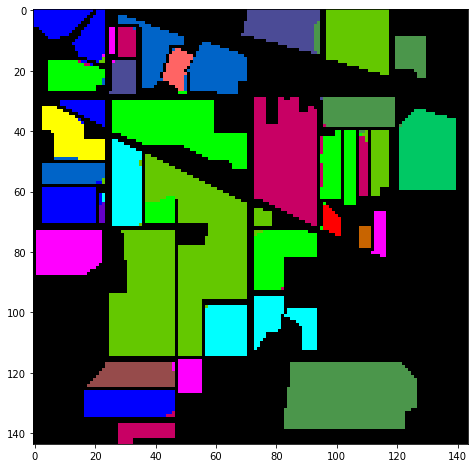

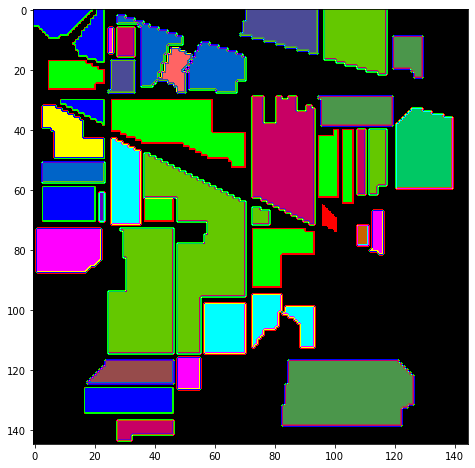

In [9]:
import spectral
m, n = OutputWhole_cc_show.shape
#output=np.reshape(output, [classcount, m*n])
#target=np.reshape(target, [1, ])  #groundtruth label
#m,n=output.size()
#L_output=np.argmax(output, axis=0) # output label
#_,L_output=torch.topk(output, 1, 0, True)
target=gt
output_c=OutputWhole_cc_show

count=0
for i in range(m):
    for j in range(n):
        if target[i, j]==0:
            count=count+1
            output_c[i,j] = target[i,j]
spectral.imshow(classes=output_c.astype(int),figsize=(8,8))
spectral.imshow(classes=gt.astype(int),figsize=(8,8))

ImageView object:
  Interpolation       :  <default>

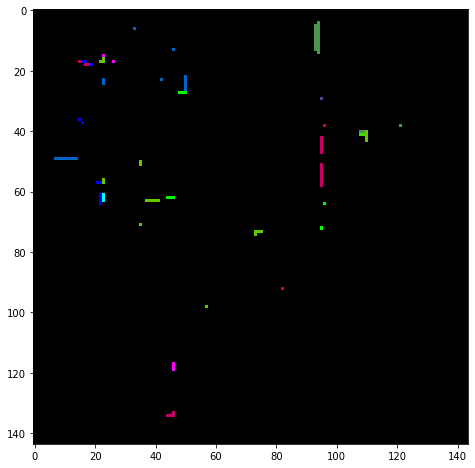

In [10]:
errors_c=output_c
for i in range(m):
    for j in range(n):
        if output_c[i,j] == gt[i,j]:
            errors_c[i,j] =0

spectral.imshow(classes=errors_c.astype(int),figsize=(8,8))